In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 계절성을 갖는 ARIMA

1. 안정적 시계열


In [11]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose # 안정적인 데이터 인지 확인
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller # 안정성 확인
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools #최적 파라메터
import warnings
warnings.filterwarnings('ignore')

In [12]:
path = "/content/drive/MyDrive/Colab Notebooks/dataset/머신러닝/monthly-milk-production.csv의 사본"
df = pd.read_csv(path)

In [13]:
pd.to_datetime(df["Month"])
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month" , inplace=True)

## 안정적인 데이터 인지 확인(그래프)

In [14]:
# 계절성 분석
seasonal_decompose(df["pounds per cow"])
decomposition = seasonal_decompose(df["pounds per cow"])

<Figure size 432x288 with 0 Axes>

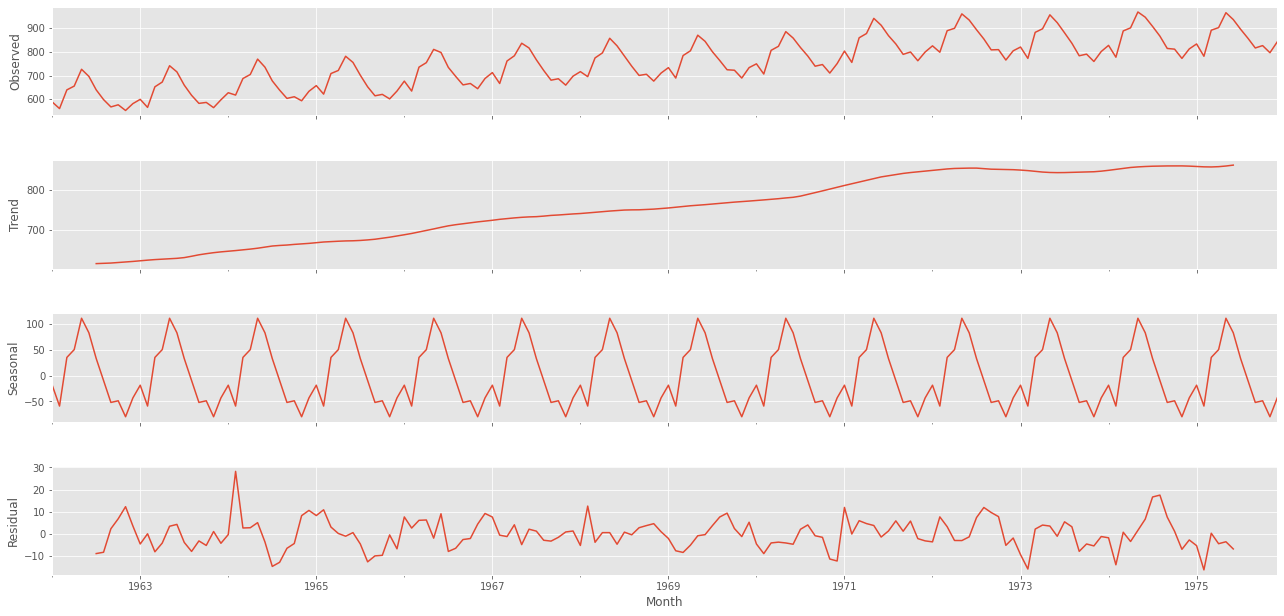

In [15]:
plt.style.use("ggplot")
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(20, 10)

## 안정성 확인
- adfuller : 매년 평균,분산,공분산 비슷한지 확인
- adfuller 사용시 결측치 있으면 안됨 .dropna()

In [16]:
df.loc[ : "1974-12-01", "pounds per cow"]

# adfuller 사용하면 알아서 4가지 1년씩 계산 해줌
result = adfuller(df.loc[ : "1974-12-01", "pounds per cow"])
result[1] # 0.5 이상이면 안정적 아님

0.6330986048291802

## 안정적이지 않은 데이터를 안정적인 데이터로 변환

- 앞의 데이터와의 차를 이용(차분)


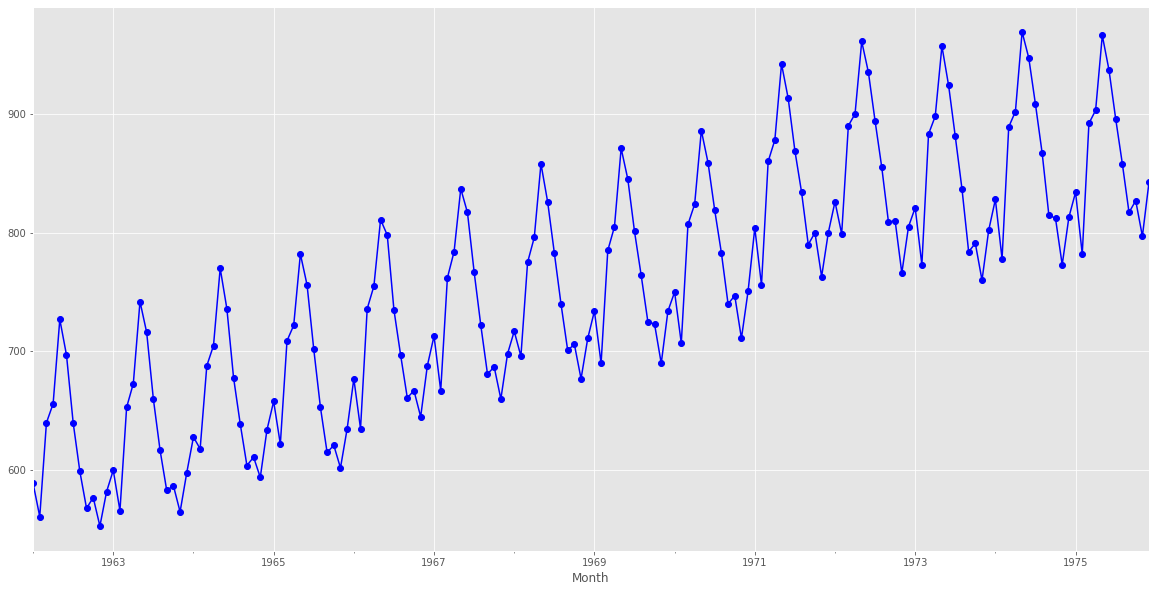

In [17]:
# 시간과 상괎없이 평균이 동일하지 않음 = 안정적이지 않은 시계열
plt.figure(figsize=(20,10))
df["pounds per cow"].plot(color="b", marker="o")

0.030068004001782136

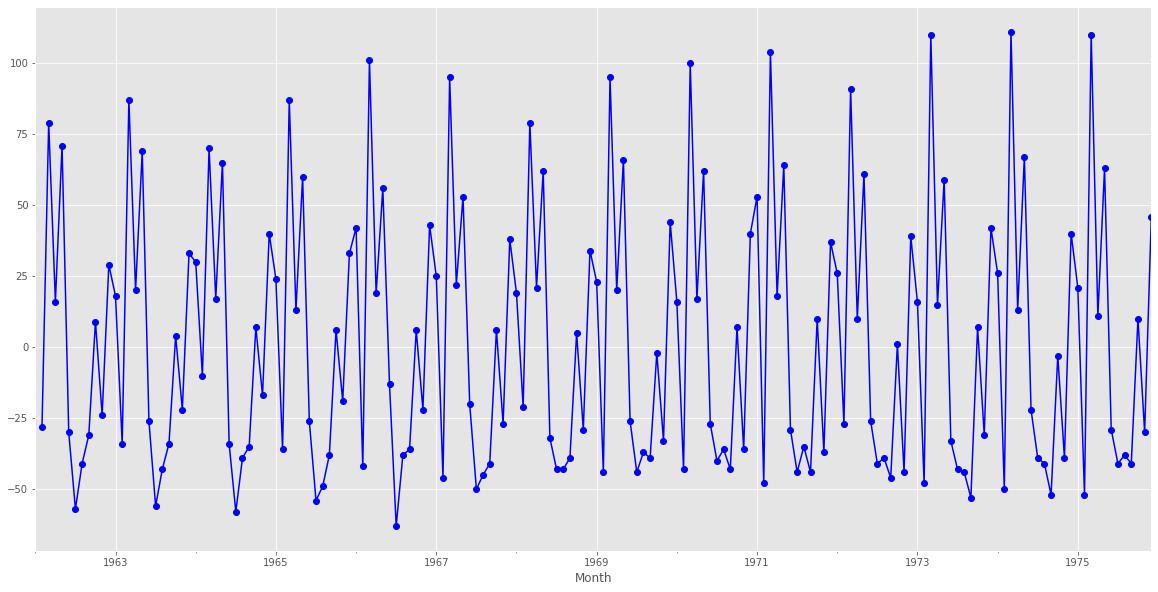

In [18]:
# 안정적인 데이터로 변환
# 기본 값 - 기본에서 한줄 내린 값
df['1st diff'] = df["pounds per cow"] - df['pounds per cow'].shift(1)
# nan값 있는 행 빼고 리턴
df["1st diff"].dropna()

# 시간과 상관없이 평균이 비슷해짐 = 안정적인 시계열
plt.figure(figsize=(20,10))
df['1st diff'].plot(color="b", marker="o")

# 안정적인지 계산 0.5미만 확인
adfuller(df["1st diff"].dropna())[1]

##한 번더 차분( 2번 차분)

1.112698933207948e-26


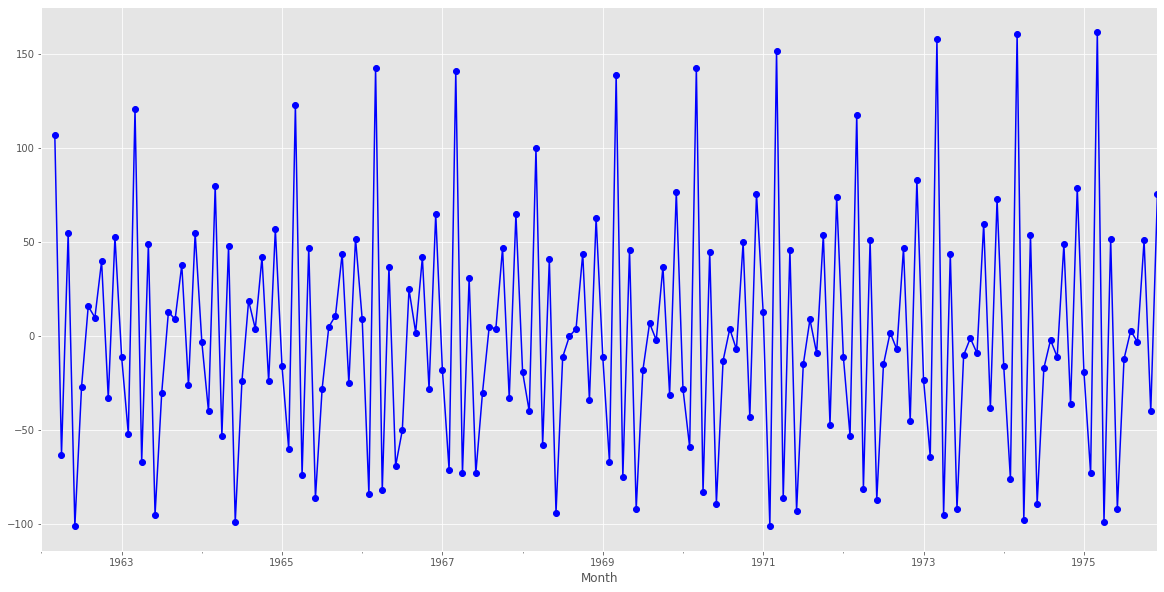

In [19]:
df["1st diff"].shift(1)
df["2nd diff"] = df["1st diff"] - df["1st diff"].shift(1)
result = adfuller(df["2nd diff"].dropna())
print(result[1])

plt.figure(figsize=(20,10))
df["2nd diff"].plot(color="b", marker="o")

계절성이 없는 ARIMA : 전데이터, 전전데이터 만 사용

계절성이 있는 ARIMA : 전, 전전, 12개월 전 데이터도 사용

In [20]:
# 데이터가 1년 주기로 반복되는것으로 추정
df['last year']=df['pounds per cow'].shift(12)
df.tail(10)[["pounds per cow", "last year"]]
df.loc["1966-01-01":"1966-12-01",:][["pounds per cow", "last year"]]

,pounds per cow,last year
Month,,
1966-01-01,677,658.0
1966-02-01,635,622.0
1966-03-01,736,709.0
1966-04-01,755,722.0
1966-05-01,811,782.0
1966-06-01,798,756.0
1966-07-01,735,702.0
1966-08-01,697,653.0
1966-09-01,661,615.0


In [21]:
model = SARIMAX(
    df.loc[ : "1974-12-01", "pounds per cow"],
    order = (0,1,0),
    seasonal_order=(0,1,0,12)
    )
# df.loc[:"1974-12-01", "pounds per cow"] 분석
results = model.fit()

# 결과 조회
print(results.summary())

# 1974-12-1일 이후 12개의 데이터 예측
results.forecast(12)

# 예측값 pred 저장
df.loc["1975-01-01": , "pred"] = results.forecast(12)

df[["pounds per cow", "pred"]].loc["1975-01-01":,:]

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -518.390
Date:                            Sun, 05 Sep 2021   AIC                           1038.780
Time:                                    07:03:46   BIC                           1041.743
Sample:                                01-01-1962   HQIC                          1039.984
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        82.4639      6.573     12.546      0.000      69.581      95.347
Ljung-Box (Q):                     

,pounds per cow,pred
Month,,
1975-01-01,834,839.0
1975-02-01,782,789.0
1975-03-01,892,900.0
1975-04-01,903,913.0
1975-05-01,966,980.0
1975-06-01,937,958.0
1975-07-01,896,919.0
1975-08-01,858,878.0
1975-09-01,817,826.0


## 최적의 파라미터 : AIC

In [ ]:
p = range(0,6) 
d = range(0,6)
q = range(0,6)

order_list = list(itertools.product(p, d, q))
order_list

# 12개월전, 24개월 전의 데이터 보도록 옵션
# 12 : 12개단위로 쪼개짐
s = range(12,13)
sorder_list = list(itertools.product(p, d, q, s))
sorder_list

In [23]:
# 뭐가 제일 좋은 파라메터? AIC가 가장 작은것

for od in order_list:
  for sod in sorder_list:
    print("od = ", od)
    print("sod = ", sod)
    try:
      mod = SARIMAX(
          df.loc[:"1974-12-31", "pounds per cow"],
          order = od,
          seasonal_order = sod)
      results = mod.fit()
      print("aic = ", results.aic)
      print("=" * 100) 

    except Exception as e:
      print("except: e = ", e)
      print("="*100)  

od =  (0, 0, 0)
sod =  (0, 0, 0, 12)
aic =  2511.4449112677116
od =  (0, 0, 0)
sod =  (0, 0, 1, 12)
aic =  2340.782909151395
od =  (0, 0, 0)
sod =  (0, 0, 2, 12)
aic =  2189.4402387578302
od =  (0, 0, 0)
sod =  (0, 0, 3, 12)
aic =  2064.5202435383653
od =  (0, 0, 0)
sod =  (0, 0, 4, 12)
aic =  1960.0540039239665
od =  (0, 0, 0)
sod =  (0, 0, 5, 12)
except: e =  maxlag should be < nobs
od =  (0, 0, 0)
sod =  (0, 1, 0, 12)
aic =  1349.3200342937753
od =  (0, 0, 0)
sod =  (0, 1, 1, 12)
aic =  1314.0923931521534
od =  (0, 0, 0)
sod =  (0, 1, 2, 12)
aic =  1313.73766778149
od =  (0, 0, 0)
sod =  (0, 1, 3, 12)
aic =  1299.3631237796922
od =  (0, 0, 0)
sod =  (0, 1, 4, 12)
except: e =  maxlag should be < nobs
od =  (0, 0, 0)
sod =  (0, 1, 5, 12)
except: e =  maxlag should be < nobs
od =  (0, 0, 0)
sod =  (0, 2, 0, 12)
aic =  1227.0707955112903
od =  (0, 0, 0)
sod =  (0, 2, 1, 12)
aic =  1157.3433906550435
od =  (0, 0, 0)
sod =  (0, 2, 2, 12)
aic =  1159.214078381311
od =  (0, 0, 0)
sod =  (0,

KeyboardInterrupt: ignored

In [ ]:
model = SARIMAX(
                  df.loc[ : "1974-12-31", "pounds per cow"],
                  order = (0,1,1),
                seasonal_order = (0,1, 1, 12)
                )

# 예측값은 두개가 X 합쳐져서 됨
results = model.fit()
df['pred']=0
df.loc["1975-01-01":, "pred"] = results.forecast(12)
df.tail(15)


In [ ]:
plt.figure(figsize = (20, 10))
df.loc[:,"pounds per cow"].plot(color = 'b', marker = 'o')

df.loc["1975-01-01":,'pred'].plot(color = 'r', marker = 'o')

## MSE (Mean squred Error)  
-  (진짜 - 예측)^ 의 합 / 데이터수


In [ ]:
# MSE
mean_squared_error(df.loc['1975-01-01' : , "pounds per cow"],df.loc['1975-01-01' : , "pred"])